In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Escalado: 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score

# Cargamos el CSV: 
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv')

# Utilizamos 'to_csv' para guardar los datos del mismo en la carpeta de 'raw':

#df.to_csv("../data/raw/health_data.csv")

df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


Queremos conocer, en base a los datos fisiológicos y de índices de salud de los pacientes, la probabilidad de que vayan a sufrir de problemas de cardiopatía.

In [4]:
# Concretamos nuestro target = y 
print(df["Heart disease_number"].min())
print(df["Heart disease_number"].max())


7
434790


In [5]:
# Obtenemos la información sobre los tipos de datos y valores no nulos del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [6]:
# Identificamos las columnas de tipo 'object':
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)


Index(['COUNTY_NAME', 'STATE_NAME'], dtype='object')


In [7]:
df.shape

(3140, 108)

In [8]:
print(df["COUNTY_NAME"])
print(df["STATE_NAME"])

0          Autauga
1          Baldwin
2          Barbour
3             Bibb
4           Blount
           ...    
3135    Sweetwater
3136         Teton
3137         Uinta
3138      Washakie
3139        Weston
Name: COUNTY_NAME, Length: 3140, dtype: object
0       Alabama
1       Alabama
2       Alabama
3       Alabama
4       Alabama
         ...   
3135    Wyoming
3136    Wyoming
3137    Wyoming
3138    Wyoming
3139    Wyoming
Name: STATE_NAME, Length: 3140, dtype: object


In [9]:
# Decidimos eliminar las columnas "COUNTY_NAME" y "STATE_NAME" ya que no las consideramos relevantes (valores no concernientes a la predicción de salud de un paciente) para la predicción de nuestro modelo: 
df_dropped = df.drop(["COUNTY_NAME", "STATE_NAME"], axis = 1)

In [10]:
df_dropped.shape

(3140, 106)

In [11]:
df_dropped.columns

Index(['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop',
       ...
       'COPD_number', 'diabetes_prevalence', 'diabetes_Lower 95% CI',
       'diabetes_Upper 95% CI', 'diabetes_number', 'CKD_prevalence',
       'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number',
       'Urban_rural_code'],
      dtype='object', length=106)

In [12]:
print(f"La dimensión del DataFrame es: {df_dropped.shape} (filas, columnas)")

La dimensión del DataFrame es: (3140, 106) (filas, columnas)


In [13]:
# Usamos el método duplicated() para detectar duplicados en un DataFrame y sum() para contar el número de duplicados.
duplicados = df_dropped.duplicated()
num_duplicados = duplicados.sum()

print(duplicados)
print(f'El número de duplicados es: {num_duplicados}')

0       False
1       False
2       False
3       False
4       False
        ...  
3135    False
3136    False
3137    False
3138    False
3139    False
Length: 3140, dtype: bool
El número de duplicados es: 0


In [24]:
# Escalado: 

data_types = df_dropped.dtypes
# El resultado de esta línea será una lista (numeric_columns) que contiene los nombres de todas las columnas numéricas en df_dropped, excluyendo la columna "Heart disease_number".
numeric_columns = [c for c in list(data_types[data_types != "object"].index) if c != "Heart disease_number"]

scaler = StandardScaler()
norm_features = scaler.fit_transform(df_dropped[numeric_columns])

# Creamos un DataFrame con las variables numéricas escaladas: 

df_dropped_scaled = pd.DataFrame(norm_features, index = df_dropped.index, columns = numeric_columns)
df_dropped_scaled["Heart disease_number"] = df_dropped["Heart disease_number"]

df_dropped_scaled.head()


,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code,Heart disease_number
0,-1.940874,-0.145679,-0.142421,0.158006,-0.135556,0.573496,-0.153144,0.027610,-0.139384,0.588469,...,-0.063696,-0.071720,-0.089834,-0.129902,-0.609615,-0.582796,-0.669652,-0.147523,-1.082865,3345
1,-1.940742,0.341296,0.287476,-0.242861,0.320383,-0.193107,0.183774,-0.469965,0.230620,-0.110300,...,-0.394103,-0.414900,-0.337677,0.376251,-0.433549,-0.393279,-0.343373,0.389791,-0.420704,13414
2,-1.940610,-0.237785,-0.239429,-0.419441,-0.246181,-0.439718,-0.225971,0.272104,-0.218759,0.656538,...,2.432709,2.483064,2.317776,-0.183415,1.855312,1.880929,1.777443,-0.204321,0.903618,2159
3,-1.940478,-0.245223,-0.246032,-0.426966,-0.254791,-0.609076,-0.230792,0.396168,-0.220555,1.264959,...,0.376846,0.423984,0.299632,-0.229096,-0.257483,-0.203761,-0.180233,-0.242100,-1.745026,1533
4,-1.940346,-0.138966,-0.135053,0.186249,-0.137140,0.216679,-0.155888,-0.200808,-0.143570,0.088582,...,0.156575,0.195197,0.158008,-0.111247,-0.081417,-0.014244,-0.017093,-0.124105,-1.745026,4101


# Regularización Lineal: 

## Selección de las variables: 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

# Selección de las variables: 
X_train = df_dropped_scaled.drop(["Heart disease_number"], axis = 1)
y_train = df_dropped_scaled["Heart disease_number"]

# Regularización Lineal: 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
train_index = list(X_train.index)
test_index = list(X_test.index)

# Selección de características usando 'SelectKBest' y 'f_regression':
k = int(len(X_train.columns) * 0.3)
selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()

# Transformación de los conjuntos de datos de entrenamiento y prueba para conservar solo las características seleccionadas:
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()


,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,...,Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),Total Population,Population Aged 60+,county_pop2018_18 and older,anycondition_number,Obesity_number,COPD_number,diabetes_number,CKD_number
0,-0.232556,-0.227731,-0.234284,-0.232951,-0.226353,-0.231316,-0.229599,-0.233425,-0.234680,-0.234420,...,-0.212643,-0.208590,-0.231195,-0.229737,-0.233171,-0.234370,-0.232975,-0.223516,-0.218609,-0.219329
1,-0.158676,-0.178665,-0.180166,-0.188266,-0.175070,-0.161168,-0.134688,-0.105618,-0.119270,-0.091822,...,-0.116680,-0.110850,-0.150293,-0.098866,-0.152859,-0.142645,-0.155304,-0.110080,-0.131449,-0.130962
2,-0.199114,-0.211128,-0.195138,-0.166782,-0.195036,-0.194045,-0.199725,-0.219256,-0.222207,-0.205154,...,-0.192263,-0.217668,-0.197005,-0.216056,-0.195125,-0.193205,-0.201976,-0.193106,-0.189197,-0.206391
3,-0.036595,-0.037734,-0.017077,-0.057986,-0.052252,-0.033158,-0.020228,-0.032603,-0.023876,-0.046224,...,0.062458,-0.107888,-0.036940,-0.030034,-0.039882,-0.003321,0.006163,-0.007077,-0.047515,-0.045054
4,0.090839,0.094680,0.101662,0.056721,0.042392,0.068095,0.101699,0.144664,0.140685,0.166099,...,0.274818,0.194913,0.097767,0.161314,0.088485,0.165555,0.182740,0.265603,0.123040,0.132454


## Modelado: 

In [16]:
# Modelo: 
lin_reg = LinearRegression()

#Entrenamiento:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [17]:
# Predicción:
y_pred = lin_reg.predict(X_test)
y_pred

array([ 5.77035247e+02,  1.33845547e+04,  1.86340352e+03,  6.78260034e+03,
        1.11947702e+04,  1.69886123e+03,  8.53321643e+02,  1.16060146e+03,
        2.75730547e+02,  1.06502209e+03,  1.30225066e+03,  2.88395165e+02,
        4.46584914e+03,  1.44514882e+03,  9.25775449e+03,  2.66011361e+03,
        5.27124708e+04,  1.26647800e+03,  1.99256307e+03,  3.36669194e+02,
        1.54284858e+03,  6.58102938e+02,  7.52388580e+02,  4.03341314e+02,
        9.80090310e+04,  2.43773824e+03,  7.10910511e+02,  2.13867820e+03,
        9.17320824e+02,  1.79676408e+02,  1.03241555e+03,  2.12768055e+03,
        2.53722893e+03,  2.94069602e+03,  8.61839537e+03,  1.43596950e+03,
        2.95262305e+03,  1.46561685e+03,  9.07323730e+02,  1.91624786e+03,
        1.40979388e+03,  8.66077017e+03,  3.52792313e+02,  1.06148838e+02,
        2.77468722e+03,  5.65463537e+02,  2.39404654e+02,  8.15091755e+03,
        9.57161173e+02,  9.29431873e+02,  1.86428950e+04,  2.21729235e+02,
        1.47693189e+03,  

In [39]:
# Métricas:
mse_rl = mean_squared_error(y_test, y_pred)
rmse_rl = np.sqrt(mse_rl)
r2_rl = r2_score(y_test, y_pred)

print("MSE: ", mse_rl)
print("RMSE: ", rmse_rl)
print("Coeficiente de determinación: ", r2_rl)

MSE:  179545.92489714027
RMSE:  423.72859815823176
Coeficiente de determinación:  0.9979486438568417


Si la variable está medida en KG, un RMSE de 423.72859815823176 dice que en promedio se equivoca en ese valor.

Si nos apoyamos en el valor del R2, observamos que es de un 99%, un valor muy alto, popr lo que el 99% de los datos están explicados por el modelo, un resultado bastante satisfactorio.

Sin embargo, el indicador RMSE es demasiado alto, nos habla de un grado muy elevado de error. Esto quizá suceda porque los valores de nuestra variable son muy dispares. 
Vamos a visualizar su valor mínimo y su valor máximo: 

In [21]:
# Max and min of the Heart disease_number column: 
print(f"El valor mínimo de la variable Heart disease number es: {df['Heart disease_number'].min()}")
print(f"El valor máximo de la variable Heart disease number es: {df['Heart disease_number'].max()}")


El valor mínimo de la variable Heart disease number es: 7
El valor máximo de la variable Heart disease number es: 434790


- El amplio rango de valores en nuestra variable dependiente puede estar influyendo significativamente en el valor de la métrica RMSE (Root Mean Square Error).

- El rango de la variable Heart disease_number va desde 7 hasta 434,790. Esto indica una gran variabilidad en los valores de la variable dependiente.

## Normalización del RMSE:
Para tener una mejor perspectiva, considerararemos la normalización del RMSE respecto al rango de la variable dependiente o su media.

NRMSE = RMSE / max−min

NRMSE= 423.72859815823176 / 434790−7  ≈0.0009 (aprox)

Ahora lo vemos mucho mejor, y podemos afirmar que nuestro grado de error es ínfimo. 

## Regularización Lasso: 

In [37]:
# Modelo:
reg_lasso = Lasso(alpha = 6, max_iter = 1000)

# Entrenamiento:
reg_lasso.fit(X_train, y_train)

# Predicción:
y_pred = reg_lasso.predict(X_test)
y_pred

# Métricas
mse_l1 = mean_squared_error(y_test, y_pred)
rmse_l1 = np.sqrt(mse_l1)
r2_l1 = r2_score(y_test, y_pred)

print("MSE: ", mse_l1)
print("RMSE: ", rmse_l1)
print("Coeficiente de determinación: ", r2_l1)

MSE:  179545.92489714027
RMSE:  423.72859815823176
Coeficiente de determinación:  0.9979486438568417


/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.246e+08, tolerance: 7.097e+07
  model = cd_fast.enet_coordinate_descent(


Hemos ido variando el valor de nuestro hiperparámetro alpha para testear, poco a poco, el cambio en la accuracy de las métricas.
Hemos empezado tomando como primer valor de prueba el '0.00', para ir, paulatinamente, suibiendo el número hasta '20'. 

Nos hemos percatado que a partir de los valores > 7, la accuracy de todas nuestras métricas iba disminuyendo, por lo que, finalmente decidimos establecer alpha = 6. 

- MSE y RMSE: hemos de tener en cuenta las consideraciones anteriores respecto a la normalización del RMSE, y, estar seguros de que aunque parezcan valores muy altos para el grado de error, esto es debido a la disparidad de los valores de la columna Heart disease_number. 

- Coeficiente de determinación: es de un 99%, es decir, tenemos un alto grado de satisfacción con el modelo. 

# Visualización de las métricas y su rendimiento:

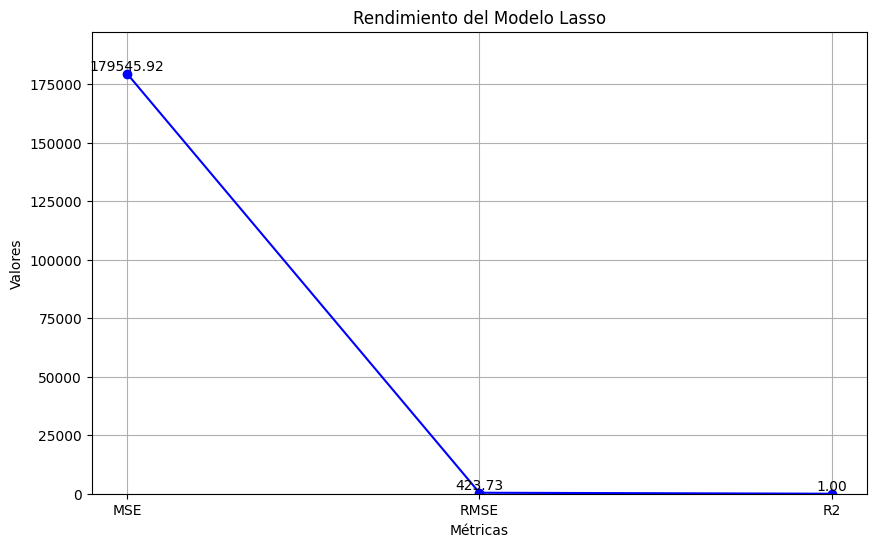

In [40]:
# Creamos datos para el diagrama de líneas:
metric_names = ['MSE', 'RMSE', 'R2']
metric_values = [mse_l1, rmse_l1, r2_l1]

# Ploteamos los datos:
plt.figure(figsize=(10, 6))
plt.plot(metric_names, metric_values, marker='o', linestyle='-', color='b')
plt.title('Rendimiento del Modelo Lasso')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.ylim(0, 1.1 * max(metric_values))  # Ajustar el límite del eje y para mejor visualización
plt.grid(True)

# Añadimos valores de las métricas encima de los puntos:
for i, value in enumerate(metric_values):
    plt.text(metric_names[i], value, f'{value:.2f}', ha='center', va='bottom')

plt.show()